<a href="https://colab.research.google.com/github/kfahn22/computer-vision-course/blob/labeled-image-demo/OWLV2_labeled_image_dataset_with_annotations.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Generating a labeled dataset using OWLv2

In this notebook, we are going to demo how to create a dataset of labeled images using OWLv2. Like its predecessor OWL-ViT, OWLv2 is a zero-shot text-conditioned object detection model. OWL-ViT was introduced in [Simple Open-Vocabulary Object Detection with Vision Transformers](https://arxiv.org/abs/2205.06230) by Minderer, et. al., and OWLv2 was introduced in [Scaling Open-Vocabulary Object Detection](https://arxiv.org/pdf/2306.09683.pdf) by Minderer, et. al. You can learn more about the OWLv2 model [here](https://huggingface.co/docs/transformers/model_doc/owlv2).

The notebook is adapted from [here](https://github.com/huggingface/notebooks/blob/main/examples/zeroshot_object_detection_with_owlvit.ipynb).

Run this cell if you have generated a large dataset. It is unnecessary for this toy example.

In [ ]:
!apt-get install git-lfs

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
git-lfs is already the newest version (3.0.2-1ubuntu0.2).
0 upgraded, 0 newly installed, 0 to remove and 31 not upgraded.


First, let's install the dependencies.

In [1]:
!pip install -q transformers huggingface_hub datasets

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 507.1/507.1 kB 12.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 115.3/115.3 kB 17.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 19.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 20.0 MB/s eta 0:00:00


Let's log into the Hugging Face Hub with our WRITE access token.

In [2]:
from huggingface_hub import notebook_login

notebook_login()

We need CUDA to run this notebook.

In [3]:
import torch

# Use GPU if available
if torch.cuda.is_available():
    device = torch.device("cuda")
else:
    device = torch.device("cpu")

Let's write a function to use Owlv2 to detect the objects in an image and return an annotated image with bounding boxes and a list of object names.

In [13]:
import matplotlib.pyplot as plt

# Process the image and retrieve the significant texts
def get_predictions(image, text_queries, model, processor, score_threshold, path):
    # Process the image, and text queries
    inputs = processor(text=text_queries, images=image, return_tensors="pt").to(device)

    # Set model in evaluation mode
    model = model.to(device)
    model.eval()

    # Get predictions
    with torch.no_grad():
      outputs = model(**inputs)

    # Get prediction logits
    logits = torch.max(outputs["logits"][0], dim=-1)
    scores = torch.sigmoid(logits.values).cpu().detach().numpy()

    # Get prediction labels and boundary boxes
    labels = logits.indices.cpu().detach().numpy()
    boxes = outputs["pred_boxes"][0].cpu().detach().numpy()

    significant_labels = []
    fig, ax = plt.subplots(1, 1, figsize=(8, 8))
    ax.imshow(image, extent=(0, 1, 1, 0))
    ax.set_axis_off()

    # Threshold to eliminate low probability predictions
    for score, box, label in zip(scores, boxes, labels):
      if score < score_threshold:
        continue
      else:
        cx, cy, w, h = box
        ax.plot([cx-w/2, cx+w/2, cx+w/2, cx-w/2, cx-w/2],
              [cy-h/2, cy-h/2, cy+h/2, cy+h/2, cy-h/2], "r")
        ax.text(
          cx - w / 2,
          cy + h / 2 + 0.015,
          f"{text_queries[label]}: {score:1.2f}",
          ha="left",
          va="top",
          color="red",
          bbox={
              "facecolor": "white",
              "edgecolor": "blue",
              "boxstyle": "square,pad=.2"
          })
        fig.savefig(path)
        plt.close()
        significant_labels.append(text_queries[label])
    return list(set(significant_labels))

Let's add a helper function to generate a label for the image. If the model does not detect any objects, the label be "None."

In [6]:
def add_labels(labels):
    if not labels:
        return "None"
    else:
        return ', '.join(labels)

We are all set to process the images!  We will pass our images and a list of text queries to the model and will get back a list of detected objects. It is important to note that we also need to set a score threshold for how confident the model should be that a  object has been detected.

*Pro Tip:*

  You might need to experiment with different values for the score threshold to prevent false positives.

In [34]:
import os
import requests
from PIL import Image
from io import BytesIO
from transformers import Owlv2Processor, Owlv2ForObjectDetection

# We will grab some images from the hf-vison course-assets
url = "https://huggingface.co/datasets/hf-vision/course-assets/resolve/main/label_dataset_owlv2"

# Alternately, you can load images from a local folder
# path = ""

# Set the text queries
text_queries = ["dog", "table", "chair", "book", "bookcase", "fireplace", "plant", "tree", "mountain", "lake", "light", "window", "basketball", "soccer ball", "volleyball", "hola hoop", "car"]

# Set the number of images to generate
num_images = 10

# Set the score threshold
score_threshold = 0.18

# Create a directory for the annotated images
annotated_images_dir = "/content/annotated_images"
os.makedirs(annotated_images_dir, exist_ok=True)

# Write a function to add images to the dataset
def add_images(idx, text_queries):
    processor = Owlv2Processor.from_pretrained("google/owlv2-base-patch16-ensemble")
    model = Owlv2ForObjectDetection.from_pretrained("google/owlv2-base-patch16-ensemble")

    # Get the URL for an image
    image_url = f'{url}/{idx}.jpeg'

    # Download the image
    response = requests.get(image_url)
    image_content = response.content

    # Open the image using PIL
    image = Image.open(BytesIO(image_content))

    # Alternately, you can load images from a local folder
    # image = Image.open(f'{path}/{idx}.jpeg').

    # Get predictions
    annotated_path = f'{annotated_images_dir}/{idx}.jpeg'
    # Get predictions
    labels = get_predictions(image, text_queries, model, processor, score_threshold, annotated_path)
    label = add_labels(labels)
    annotated_image = Image.open(annotated_path)

    # Add image and label to the dataset
    return {
        "image": image,
        "annotated_image": annotated_image,
        "label": label,
    }

def generate_entries():
    for i in range(num_images):
        yield add_images(i, text_queries)

We are now ready to push our dataset to the Hugging Face hub. We have a couple of options on how to do this.

* Use an image folder with a metajsonl file
* Use a generator

We are going to demo using the generator method, which is a memory-efficient way to create a dataset because it iterates through the images. You can read more about adding a dataset [here](https://huggingface.co/docs/datasets/en/create_dataset).

In [35]:
from datasets import Dataset

username = "kfahn"
repo_id = "labeled_images_demo"

# Create a dataset from the generator
ds = Dataset.from_generator(generate_entries)
ds.push_to_hub(f'{username}/{repo_id}')

Generating train split: 0 examples [00:00, ? examples/s]

Uploading the dataset shards:   0%|          | 0/1 [00:00<?, ?it/s]

Map:   0%|          | 0/10 [00:00<?, ? examples/s]

Creating parquet from Arrow format:   0%|          | 0/1 [00:00<?, ?ba/s]

README.md:   0%|          | 0.00/353 [00:00<?, ?B/s]

CommitInfo(commit_url='https://huggingface.co/datasets/kfahn/labeled_images_demo/commit/5bb889bbf9fe717cb6c1b49bbb65043e41bdc60c', commit_message='Upload dataset', commit_description='', oid='5bb889bbf9fe717cb6c1b49bbb65043e41bdc60c', pr_url=None, pr_revision=None, pr_num=None)

In [36]:
from datasets import load_dataset

# Load the dataset
dataset = load_dataset('kfahn/labeled_images_demo')


Generating train split:   0%|          | 0/10 [00:00<?, ? examples/s]

Let's take a look at one of the image, label pairs in our new dataset. The image shows a table and chairs with some lights and a plant.

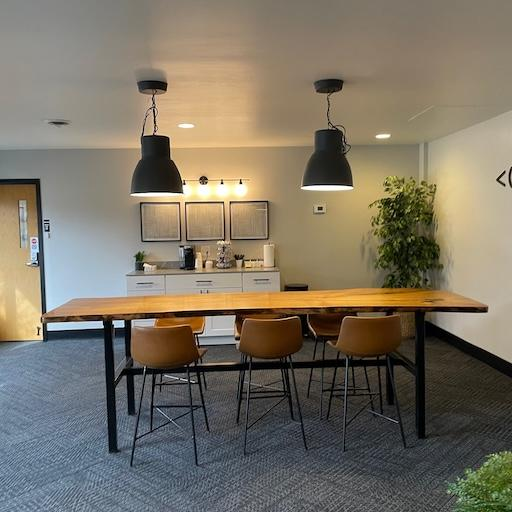

In [37]:
dataset["train"][0]["image"]

If we look at the label, we can see that the model has correctly identified the objects in the photo!

In [39]:
dataset["train"][0]["label"]

'chair, plant, light, table'

Let's also take a look at the annotated image.

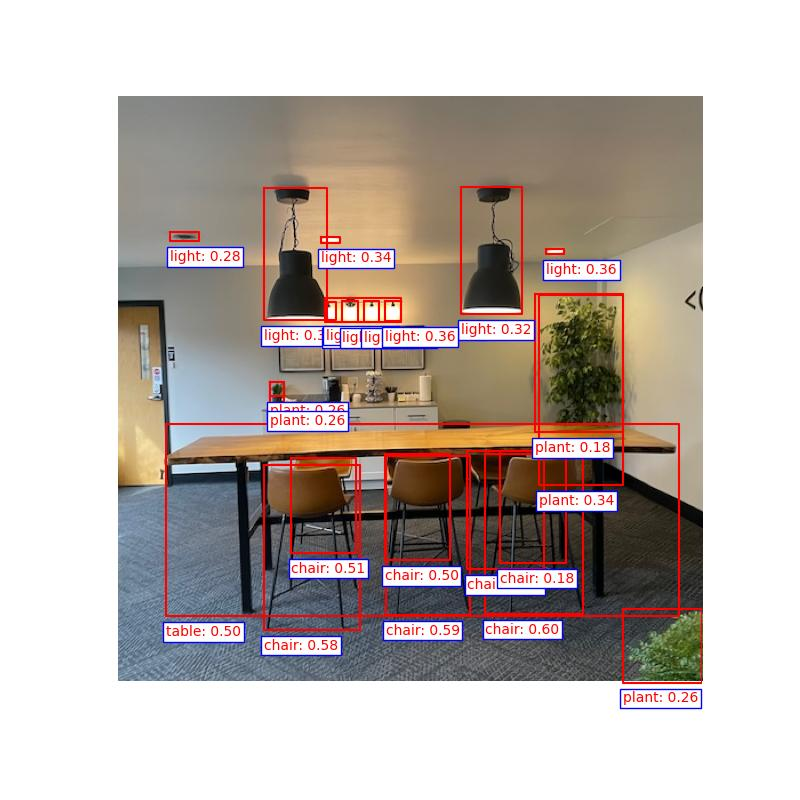

In [44]:
dataset["train"][0]["annotated_image"]

Now, let's take a look at a different image, pair.

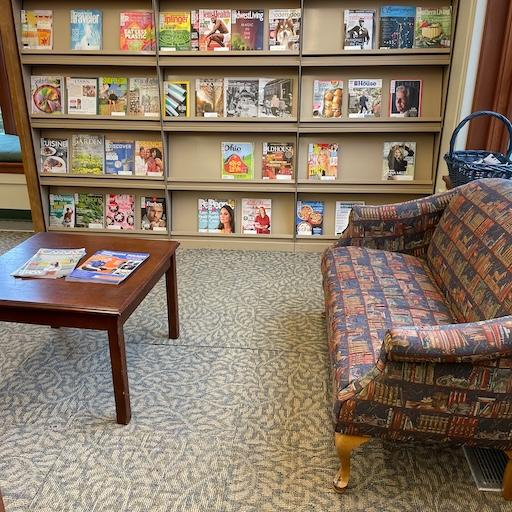

In [40]:
dataset["train"][7]["image"]

Now let's look at the label.

In [45]:
dataset["train"][7]["label"]

'dog, table, bookcase, book'

Hmmm...notice something a bit odd? The model has detected a dog in the image! This seems wrong. However, if you look closely at the annotated image, you can see that one of the magazines has a dog on the cover. This highlights the importance of double-checking the predicted labels to make sure they are what you expect.

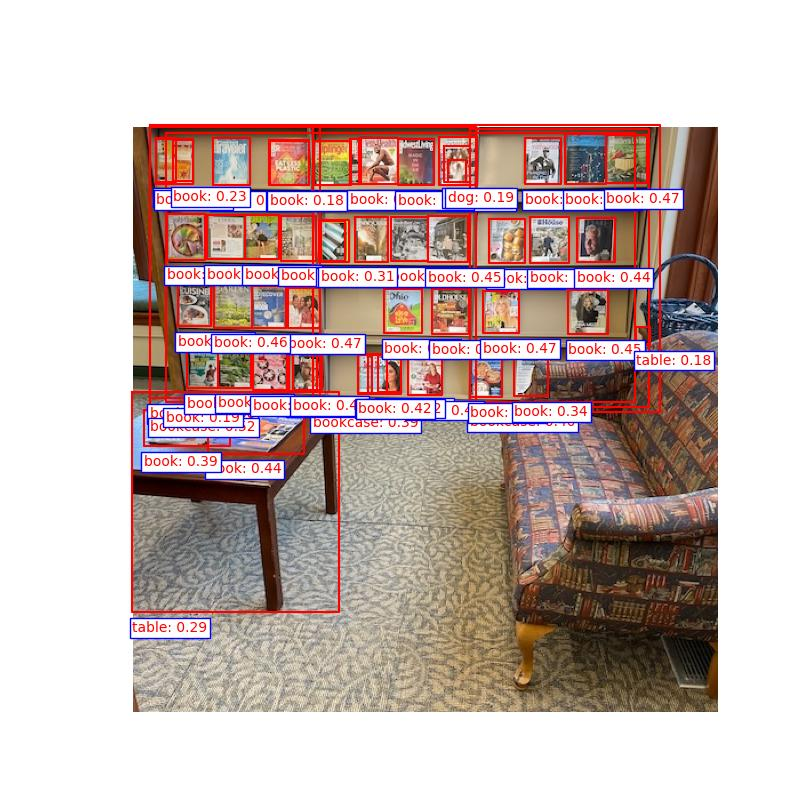

In [43]:
dataset["train"][7]["annotated_image"]